### Reference Links

https://docs.smith.langchain.com/reference/data_formats/run_data_format
https://docs.smith.langchain.com/reference/data_formats/trace_query_syntax
https://docs.smith.langchain.com/observability/how_to_guides/export_traces

# Setup

In [ ]:
#Setup tracing & key
from google.colab import userdata
import os
os.environ["LANGSMITH_TRACING_V2"] = "true"
os.environ["LANGSMITH_API_KEY"] = userdata.get('Smith2')

from langsmith import Client

client = Client()

In [ ]:
project_runs = client.list_runs(project_name="default")
print(project_runs)

<generator object Client.list_runs at 0x7e4b7412e200>


In [ ]:
count = sum(1 for _ in project_runs)
print(f"The number of entries in x_llm_runs is: {count}")

The number of entries in x_llm_runs is: 821


# Method
How to **query & export runs list** into pandas

---
*Run 4 : Success !*

In [ ]:
# @title query & export runs list into pandas
from collections import defaultdict
from concurrent.futures import Future, ThreadPoolExecutor
from datetime import datetime, timedelta

from langsmith import Client
from tqdm.auto import tqdm

client = Client()
#Change as needed
project_name = "default"
num_days = 15

# List all runs
all_runs = client.list_runs(
  project_name=project_name,
  start_time=datetime.now() - timedelta(days=num_days),
  # We don't need to fetch inputs, outputs, and other values that # may increase the query time
  select=["id", "name", "run_type"],
)

data = []
futures: list[Future] = []
trace_cursor = 0
trace_batch_size = 50

all_runs_by_parent = defaultdict(lambda: defaultdict(set))
# Do not exceed rate limit
with ThreadPoolExecutor(max_workers=2) as executor:
  # Group all runs by parent run ID
  for run in tqdm(all_runs):
      # Collect all tools invoked within a given trace
      all_runs_by_parent[run.id]["tools_involved"].add(run.name)

      # Only if needed; maybe send a batch of parent run IDs to the server
      # this lets us query for the root runs in batches
      # while still processing the all runs
      #if len(all_runs_by_parent) % trace_batch_size == 0:
          #if this_batch := list(all_runs_by_parent.keys())[
              #trace_cursor : trace_cursor + trace_batch_size
          #]:
              #trace_cursor += trace_batch_size
              #futures.append(
                  #executor.submit(
                      #client.list_runs,
                      #project_name=project_name,
                      #run_ids=this_batch,
                      #select=["name", "total_cost", "status", "start_time", "total_tokens", "prompt_cost", "completion_cost", "parent_run_id"],
                  #)
              #)

  if this_batch := list(all_runs_by_parent.keys())[trace_cursor:]:
      futures.append(
          executor.submit(
              client.list_runs,
              project_name=project_name,
              run_ids=this_batch,
              select=["name","total_cost", "status", "start_time", "total_tokens", "prompt_cost", "completion_cost", "parent_run_id"],
          )
      )


for future in tqdm(futures):
  root_runs = future.result()
  for root_run in root_runs:
      root_data = all_runs_by_parent[root_run.id]
      data.append(
          {
              "run_id": root_run.id,
              "run_name": root_run.name,
              "run_type": root_run.run_type,
              "total_cost (USD)": root_run.total_cost,
              "status": root_run.status,
              "start_time": root_run.start_time,
              "total_tokens": root_run.total_tokens,
              "prompt_cost": root_run.prompt_cost,
              "completion_cost": root_run.completion_cost,
              "parent_run_id": root_run.parent_run_id,
              "tools_involved": list(root_data["tools_involved"]),
          }
      )

# (Optional): Convert to a pandas DataFrame

import pandas as pd

df3 = pd.DataFrame(data)
df3.head()

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,run_id,run_name,run_type,run_total_cost (USD),status,start_time,total_tokens,prompt_cost,completion_cost,parent_run_id,tools_involved
0,044383e6-960d-4247-8376-7021c0c4eee0,ChatGoogleGenerativeAI,llm,0.0001644,success,2025-07-04 06:40:44.014998,891,0.000064,0.0001004,2629d3b9-4f0c-4349-9e1b-d113d4327564,[ChatGoogleGenerativeAI]
1,8c8d20dd-4fd1-4434-9cdc-532528493ece,ChatPromptTemplate,prompt,None,success,2025-07-04 06:40:44.012777,0,None,None,2629d3b9-4f0c-4349-9e1b-d113d4327564,[ChatPromptTemplate]
2,2629d3b9-4f0c-4349-9e1b-d113d4327564,generate_final_summary,chain,0.0001644,success,2025-07-04 06:40:44.011392,891,0.000064,0.0001004,ba1658d0-04eb-4b27-ad0b-7aa820c0c34e,[generate_final_summary]
3,58be752a-e479-42a9-b912-0f410cfdd57c,should_collapse,chain,None,success,2025-07-04 06:40:43.818791,0,None,None,88977ece-a395-4546-b6b7-823123468eff,[should_collapse]
4,d487ef08-b209-4c6c-b2fb-a0bb45422b31,ChatGoogleGenerativeAI,llm,0.0000935,success,2025-07-04 06:40:42.209069,509,0.0000367,0.0000568,88977ece-a395-4546-b6b7-823123468eff,[ChatGoogleGenerativeAI]


In [ ]:
#rows count
print(f"The total number of rows in the DataFrame is: {df3.shape[0]}")

The total number of rows in the DataFrame is: 807


##### Analyse : run_type


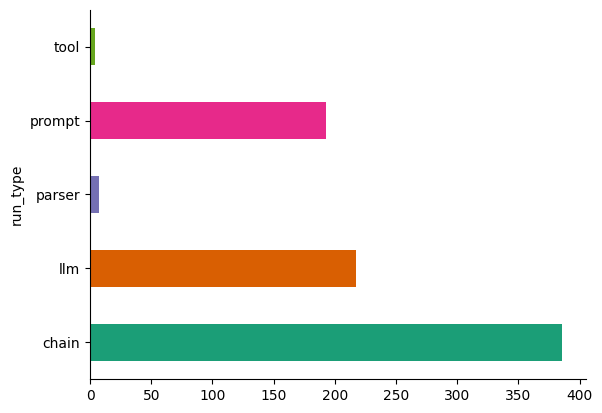

In [ ]:

from matplotlib import pyplot as plt
import seaborn as sns
df3.groupby('run_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

---

# Download Data into g sheets

In [ ]:
# DIRECTLY : Save the DataFrame to a CSV file
df3.to_csv('langsmith_runs_data.csv', index=False)
print("DataFrame saved to langsmith_runs_data.csv")

In [ ]:
# INTERACTIVE : save
from google.colab import sheets
import uuid

# Convert UUID objects to strings in the DataFrame
for col in df3.columns:
    if df3[col].apply(lambda x: isinstance(x, uuid.UUID)).any():
        df3[col] = df3[col].astype(str)

sheet = sheets.InteractiveSheet(df=df3)

https://docs.google.com/spreadsheets/d/12ymMMy6aNMsTxisb8MsWvg9EkQ6okOI_9WVJCwgEAfU/edit#gid=0
